<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C9IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]

In [22]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# def train,test,features,y_name

In [0]:
features = ['T10','T50','T90','N+A']
y_name = 'C9IP'

# corr

In [24]:
abs(train[features+[y_name]].corr()).style.background_gradient()

,T10,T50,T90,N+A,C9IP
T10,1,0.894282,0.239213,0.305082,0.792988
T50,0.894282,1,0.545153,0.412805,0.812884
T90,0.239213,0.545153,1,0.229858,0.296953
N+A,0.305082,0.412805,0.229858,1,0.676207
C9IP,0.792988,0.812884,0.296953,0.676207,1


# isomap

In [0]:
from sklearn.manifold import isomap
from sklearn.preprocessing import StandardScaler
iso = isomap.Isomap(n_components=1)
scaler = StandardScaler()
#再來記得務必先做特徵縮放再做isomap
train['iso_x'] = iso.fit_transform(scaler.fit_transform(train[['T50','N+A']]))
test_170['iso_x'] = iso.transform(scaler.transform(test_170[['T50','N+A']]))
test_50['iso_x'] = iso.transform(scaler.transform(test_50[['T50','N+A']]))

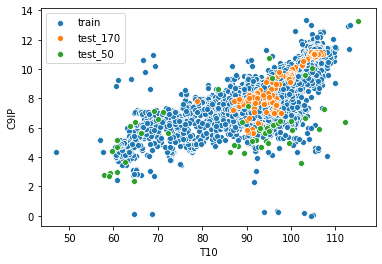

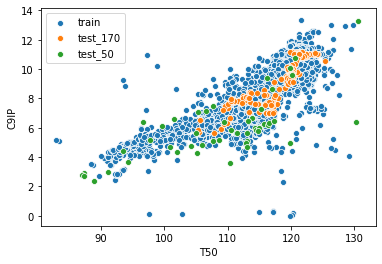

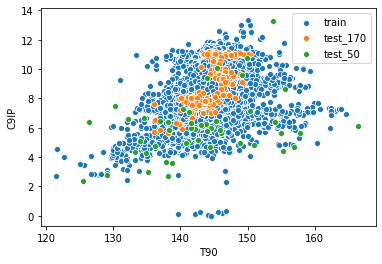

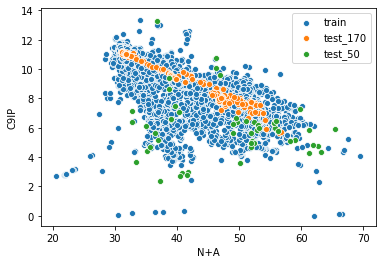

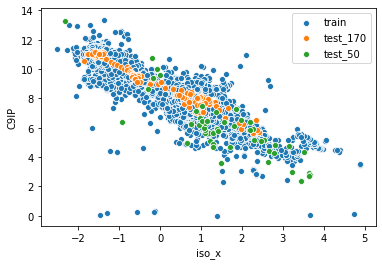

In [26]:
for x_col in features+['iso_x']:
  sns.scatterplot(x=x_col,y=y_name,data=train,label='train')
  sns.scatterplot(x=x_col,y=y_name,data=test_170,label='test_170')
  sns.scatterplot(x=x_col,y=y_name,data=test_50,label='test_50')
  plt.legend()
  plt.show()

# corr

In [27]:
abs(train[features+['iso_x']+[y_name]].corr()).style.background_gradient()

,T10,T50,T90,N+A,iso_x,C9IP
T10,1,0.894282,0.239213,0.305082,0.763583,0.792988
T50,0.894282,1,0.545153,0.412805,0.879597,0.812884
T90,0.239213,0.545153,1,0.229858,0.466403,0.296953
N+A,0.305082,0.412805,0.229858,1,0.790838,0.676207
iso_x,0.763583,0.879597,0.466403,0.790838,1,0.899705
C9IP,0.792988,0.812884,0.296953,0.676207,0.899705,1


# features select

In [0]:
features = ['iso_x']

# features scaler

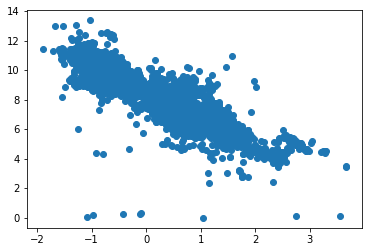

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train[features])

train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

plt.scatter(train['iso_x'],train[y_name])

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p,name):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

# modeling

In [31]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#model = DecisionTreeRegressor(max_depth=1)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
#model = SVR()
model = LinearRegression()

val_scores = cross_validate(model,train[features],train[y_name],cv=5)

print('val_scores:',val_scores['test_score'])
print('val_scores.mean:',val_scores['test_score'].mean())

# fit 
model.fit(train[features],train[y_name])
# predict
train['y_pred'] = model.predict(train[features])
test_170['y_pred'] = model.predict(test_170[features])
test_50['y_pred'] = model.predict(test_50[features])

val_scores: [0.88360746 0.66867033 0.82043764 0.72064973 0.75880354]
val_scores.mean: 0.7704337411502143


# line plot

In [0]:
by_col = 'iso_x'
train_point = train.sort_values(by = by_col)
test_170_point = test_170.sort_values(by = by_col)
test_50_point = test_50.sort_values(by = by_col)

In [0]:
def pred_plot(df,by_col,name):
  plt.plot(df[by_col],df['y_pred'],label = name+'_pred',color='red')
  plt.scatter(df[by_col],df[y_name],label= name+'_data')

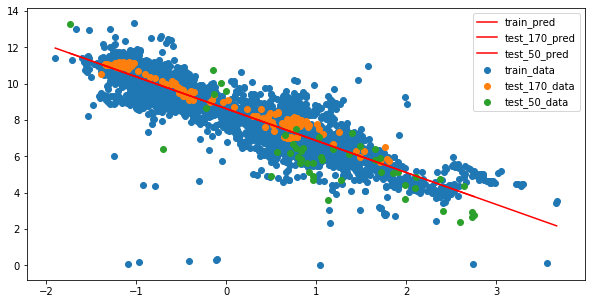

,R2,RMSE,mean_absolute_error
train,0.809468,0.852992,0.594225
test_170,0.921255,0.443798,0.380950
test_50,0.609603,1.298101,1.048318


In [34]:
fig = plt.figure(figsize=(10,5))
pred_plot(train_point,by_col,'train')
pred_plot(test_170_point,by_col,'test_170')
pred_plot(test_50_point,by_col,'test_50')
plt.legend()
plt.show()
metric(train[y_name],train['y_pred'],'train').append(
    metric(test_170[y_name],test_170['y_pred'],'test_170')).append(
        metric(test_50[y_name],test_50['y_pred'],'test_50'))

# check out

In [0]:
loss = ((test_170_point[y_name] - test_170_point['y_pred'])**2).sort_values(ascending=False)
test_170_point['out'] = False
test_170_point.loc[loss.head(5).index,'out'] = True

In [0]:
loss = ((test_50_point[y_name] - test_50_point['y_pred'])**2).sort_values(ascending=False)
test_50_point['out'] = False
test_50_point.loc[loss.head(5).index,'out'] = True

# plot out

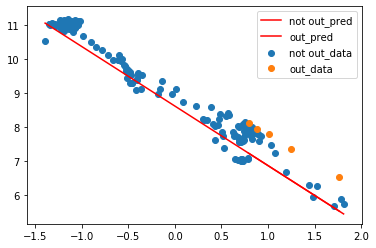

,R2,RMSE,mean_absolute_error
test_170,0.928966,0.42018,0.364255


In [37]:
pred_plot(test_170_point.loc[test_170_point.out==False],by_col,'not out')
pred_plot(test_170_point.loc[test_170_point.out==True],by_col,'out')
plt.legend()
plt.show()
metric(test_170_point.loc[test_170_point.out==False,y_name],test_170_point.loc[test_170_point.out==False,'y_pred'],name='test_170')

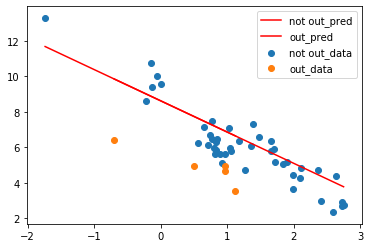

,R2,RMSE,mean_absolute_error
test_50,0.776319,1.011659,0.863406


In [38]:
pred_plot(test_50_point.loc[test_50_point.out==False],by_col,'not out')
pred_plot(test_50_point.loc[test_50_point.out==True],by_col,'out')
plt.legend()
plt.show()
metric(test_50_point.loc[test_50_point.out==False,y_name],test_50_point.loc[test_50_point.out==False,'y_pred'],name='test_50')